<a href="https://colab.research.google.com/github/ABHISHEK-max-sketch/Grammar-Scoring-Engine/blob/main/Grammar_Scoring_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mohit123verma_voiceml_path = kagglehub.dataset_download('mohit123verma/voiceml')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/voiceml/dataset/sample_submission.csv
/kaggle/input/voiceml/dataset/train.csv
/kaggle/input/voiceml/dataset/test.csv
/kaggle/input/voiceml/dataset/audios_test/audio_885.wav
/kaggle/input/voiceml/dataset/audios_test/audio_698.wav
/kaggle/input/voiceml/dataset/audios_test/audio_1176.wav
/kaggle/input/voiceml/dataset/audios_test/audio_1215.wav
/kaggle/input/voiceml/dataset/audios_test/audio_66.wav
/kaggle/input/voiceml/dataset/audios_test/audio_386.wav
/kaggle/input/voiceml/dataset/audios_test/audio_1026.wav
/kaggle/input/voiceml/dataset/audios_test/audio_330.wav
/kaggle/input/voiceml/dataset/audios_test/audio_72.wav
/kaggle/input/voiceml/dataset/audios_test/audio_858.wav
/kaggle/input/voiceml/dataset/audios_test/audio_107.wav
/kaggle/input/voiceml/dataset/audios_test/audio_820.wav
/kaggle/input/voiceml/dataset/audios_test/audio_300.wav
/kaggle/input/voiceml/dataset/audios_test/audio_435.wav
/kaggle/input/voiceml/dataset/audios_test/audio_550.wav
/kaggle/input/voiceml/datase

### Step 2: Install Required Libraries

We install essential Python packages for audio processing (`librosa`, `pydub`), speech-to-text (`openai-whisper`), NLP (`spacy`, `nltk`), grammar scoring (`language-tool-python`), and machine learning (`scikit-learn`, `torch`). We also download the small English model for spaCy.



In [ ]:
!pip install librosa pydub openai-whisper transformers sentencepiece torch pandas scikit-learn language-tool-python spacy nltk
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 17.1 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.2 M

### Step 3: Import Necessary Libraries for Audio Preprocessing

- `os`: For file path handling.
- `librosa`: A powerful library for loading and analyzing audio signals.
- `soundfile`: For reading and writing audio files.
- `pandas`: For working with tabular data (`train.csv`, `test.csv`).
- `tqdm.notebook`: For progress bars during loops, helps track long processing operations.


In [ ]:
import os
import librosa
import soundfile as sf
import pandas as pd
from tqdm.notebook import tqdm

### Step 4: Load CSV and Preprocess Audio Files 🎧

- Loaded the `train.csv` which contains `filename` and `label` (grammar score).
- Defined the preprocessing pipeline:
  - Resample audio to 16kHz.
  - Normalize the volume.
  - Trim silence from start and end.
- Saved the processed audio into a separate directory (`/kaggle/working/processed_audio`).

This step ensures consistent and clean audio for feature extraction.


In [ ]:
import os
print(os.getcwd())  # Current working directory


/kaggle/working


In [ ]:
import os
import librosa
import soundfile as sf
import pandas as pd
from tqdm.notebook import tqdm

AUDIO_DIR = '/kaggle/input/voiceml/dataset/audios_train'
CSV_PATH = '/kaggle/input/voiceml/dataset/train.csv'
PROCESSED_DIR = '/kaggle/working/processed_audio'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Load CSV and rename columns
train_df = pd.read_csv(CSV_PATH)
train_df.columns = ['filename', 'label']  # Rename for easier use

# Preprocessing function
def preprocess_audio(file_path, save_path, sr=16000):
    y, orig_sr = librosa.load(file_path, sr=None)
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr, sr)
    y = y / max(abs(y))  # Normalise volume
    y, _ = librosa.effects.trim(y, top_db=25)  # Trim silence
    sf.write(save_path, y, sr)

# Preprocess each audio
for filename in tqdm(train_df['filename']):
    in_path = os.path.join(AUDIO_DIR, filename)
    out_path = os.path.join(PROCESSED_DIR, filename)
    preprocess_audio(in_path, out_path)

print(" Audio preprocessing completed. Files saved in:", PROCESSED_DIR)

  0%|          | 0/444 [00:00<?, ?it/s]

 Audio preprocessing completed. Files saved in: /kaggle/working/processed_audio


### Inspecting Preprocessed Audio Files

In [ ]:
files = os.listdir('/kaggle/working/processed_audio')
print(f"Found {len(files)} preprocessed audio files.\nExample files:\n", files[:5])

# Check sample rate and duration of a random file
sample_file = os.path.join('/kaggle/working/processed_audio', files[0])
y, sr = librosa.load(sample_file, sr=None)

duration = librosa.get_duration(y=y, sr=sr)
print(f" Sample file: {files[0]}")
print(f" Duration: {duration:.2f} seconds")
print(f" Sample rate: {sr} Hz")

Found 444 preprocessed audio files.
Example files:
 ['audio_1266.wav', 'audio_359.wav', 'audio_886.wav', 'audio_1017.wav', 'audio_636.wav']
 Sample file: audio_1266.wav
 Duration: 57.42 seconds
 Sample rate: 16000 Hz


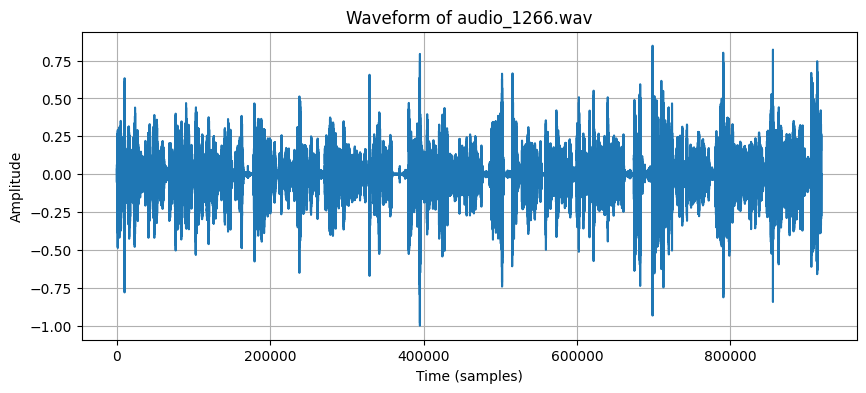

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title(f"Waveform of {files[0]}")
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

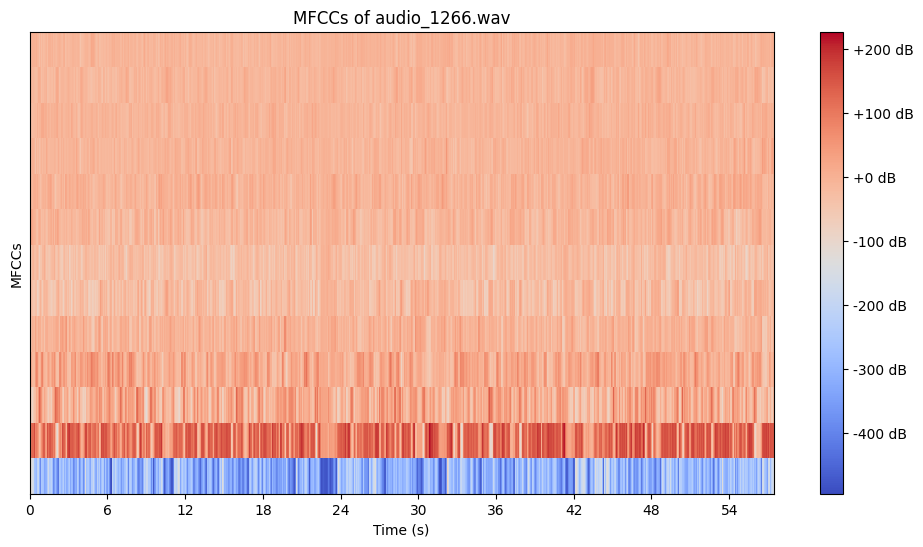

In [ ]:
# MFCC visualization
import librosa.display

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(12, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'MFCCs of {files[0]}')
plt.xlabel('Time (s)')
plt.ylabel('MFCCs')
plt.show()


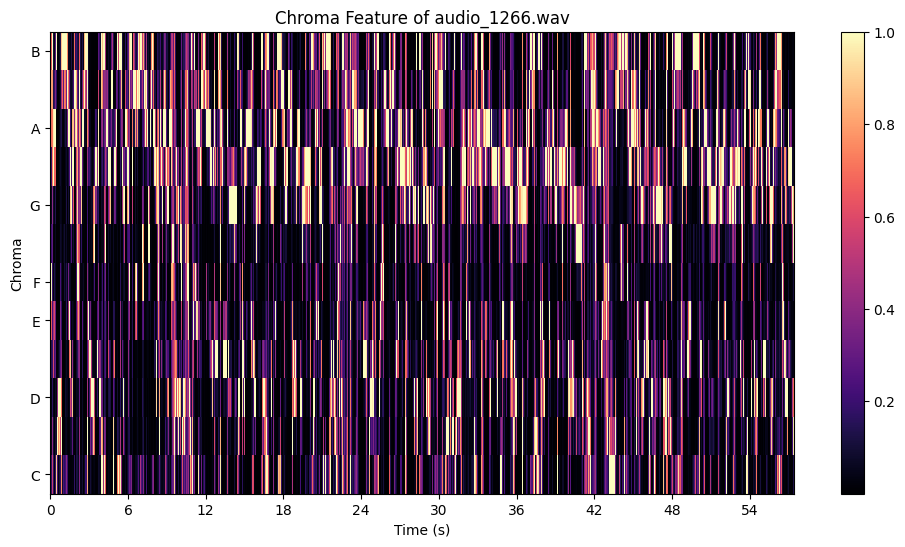

In [ ]:
# Chroma Feature visualization
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

plt.figure(figsize=(12, 6))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.title(f'Chroma Feature of {files[0]}')
plt.xlabel('Time (s)')
plt.ylabel('Chroma')
plt.show()


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Using device: {device}")

 Using device: cuda


### Whisper ASR Model for Audio Transcription

In [ ]:
import whisper
from tqdm.notebook import tqdm
import pandas as pd
import os


model = whisper.load_model("base")

transcripts = []

for fname in tqdm(train_df['filename']):
    audio_path = os.path.join('/kaggle/working/processed_audio', fname)
    result = model.transcribe(audio_path, language='en')
    transcripts.append(result['text'])

# Add transcripts to dataframe
train_df['transcript'] = transcripts

# Save updated CSV
train_df.to_csv('/kaggle/working/train_with_transcripts.csv', index=False)
print(" Transcriptions saved to: /kaggle/working/train_with_transcripts.csv")

100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 210MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

  0%|          | 0/444 [00:00<?, ?it/s]

 Transcriptions saved to: /kaggle/working/train_with_transcripts.csv


In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/working/train_with_transcripts.csv')
print(" Columns:", df.columns.tolist())
print(" Total records:", len(df))
print(" Sample transcript:\n")
print(df[['filename', 'label', 'transcript']].head(3))

 Columns: ['filename', 'label', 'transcript']
 Total records: 444
 Sample transcript:

         filename  label                                         transcript
0  audio_1261.wav    1.0   My favorite hobby is cultivation of plants su...
1   audio_942.wav    1.5   the playground looks like very clear and neat...
2  audio_1110.wav    1.5   My goal is to become an electrical employee a...


In [ ]:
# Check for empty transcripts
empty_transcripts = df['transcript'].str.strip().eq('').sum()
print(f" Empty transcripts found: {empty_transcripts}")

 Empty transcripts found: 0


### Cleaning and Preprocessing Transcripts

In [ ]:
import re

# Updated list of common disfluencies and fillers
FILLERS = ['uh', 'um', 'erm', 'you know', 'like', 'i mean', 'hmm', 'ah', 'uhh', 'huh',
           'actually', 'basically', 'seriously', 'literally', 'so', 'right', 'okay', 'well',
           'i guess', 'you see', 'just', 'basically', 'apparently', 'honestly', 'sort of', 'kinda']

def clean_transcript(text):
    text = text.lower()  # Standard casing
    text = re.sub(r'\b(?:' + '|'.join(FILLERS) + r')\b', '', text)  # Remove fillers
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces
    text = re.sub(r'\s([?.!,"])', r'\1', text)  # Remove space before punctuation
    text = text.strip()
    return text

# Load previous data
df = pd.read_csv('/kaggle/working/train_with_transcripts.csv')

# Clean all transcripts
df['cleaned_transcript'] = df['transcript'].astype(str).apply(clean_transcript)

# Save new version
df.to_csv('/kaggle/working/train_cleaned.csv', index=False)
print(" Cleaned transcripts saved to: /kaggle/working/train_cleaned.csv")


 Cleaned transcripts saved to: /kaggle/working/train_cleaned.csv


In [ ]:
print(df[['transcript', 'cleaned_transcript']].sample(3))

                                            transcript  \
209   I don't have a particular goal in my life but...   
142   So the greatest goal that I have right now is...   
220   All right my favorite place that I like to vi...   

                                    cleaned_transcript  
209  i don't have a particular goal in my life but ...  
142  the greatest goal that i have now is to be abl...  
220  all my favorite place that i to visit. i now l...  


### Extracting Grammar and NLP Features from Transcripts

In [ ]:
import spacy
import pandas as pd
from tqdm.notebook import tqdm

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Load the cleaned dataset
df = pd.read_csv('/kaggle/working/train_cleaned.csv')

# Feature lists
error_counts = []
avg_sent_lengths = []
pos_diversities = []
dep_diversities = []  # New feature for dependency tag diversity

for text in tqdm(df['cleaned_transcript']):
    # NLP parsing
    doc = nlp(text)

    # Count errors based on basic syntactic and lexical rules
    # Example: Count occurrences of "to be" verbs or missed articles
    errors = 0
    for token in doc:
        if token.dep_ in ['aux', 'det'] and token.pos_ == 'VERB':  # Example of checking auxiliary verb errors
            errors += 1
    error_counts.append(errors)

    # Sentence length and POS diversity
    sent_lengths = [len(sent) for sent in doc.sents]
    pos_tags = [token.pos_ for token in doc if token.pos_ != 'SPACE']  # Removing space tokens
    dep_tags = [token.dep_ for token in doc if token.dep_ != 'punct']  # Removing punctuation dependency tags

    # Features
    avg_sent_lengths.append(sum(sent_lengths) / len(sent_lengths) if sent_lengths else 0)
    pos_diversities.append(len(set(pos_tags)))  # Diversity of part-of-speech tags
    dep_diversities.append(len(set(dep_tags)))  # Diversity of dependency tags

# Append features to the dataframe
df['grammar_errors'] = error_counts
df['avg_sentence_length'] = avg_sent_lengths
df['pos_diversity'] = pos_diversities
df['dep_diversity'] = dep_diversities  # Added dependency tag diversity feature

# Save the updated dataframe
df.to_csv('/kaggle/working/train_with_nlp_features.csv', index=False)
print(" Grammar features and NLP analysis saved to: /kaggle/working/train_with_nlp_features.csv")


  0%|          | 0/444 [00:00<?, ?it/s]

 Grammar features and NLP analysis saved to: /kaggle/working/train_with_nlp_features.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


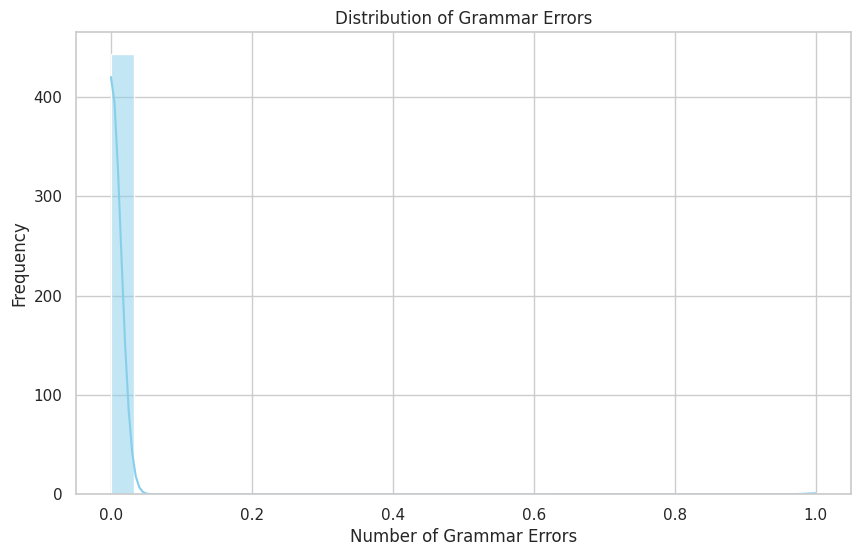

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


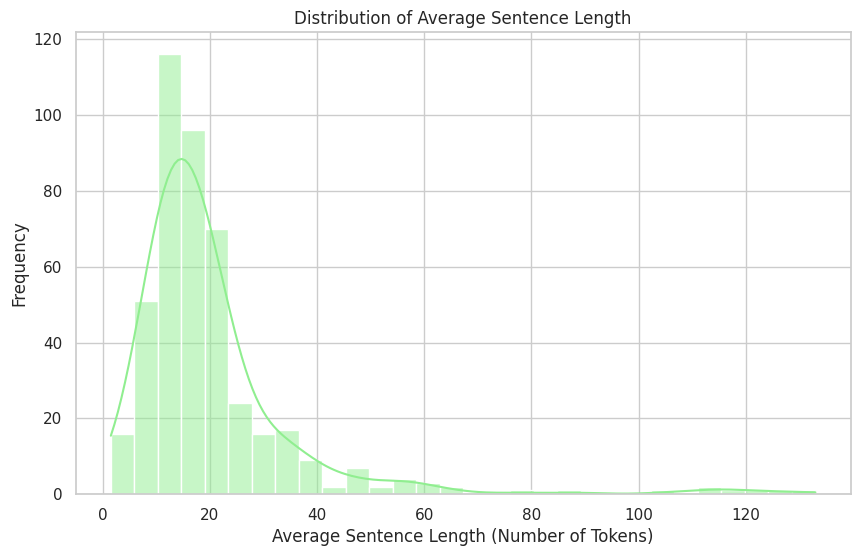

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


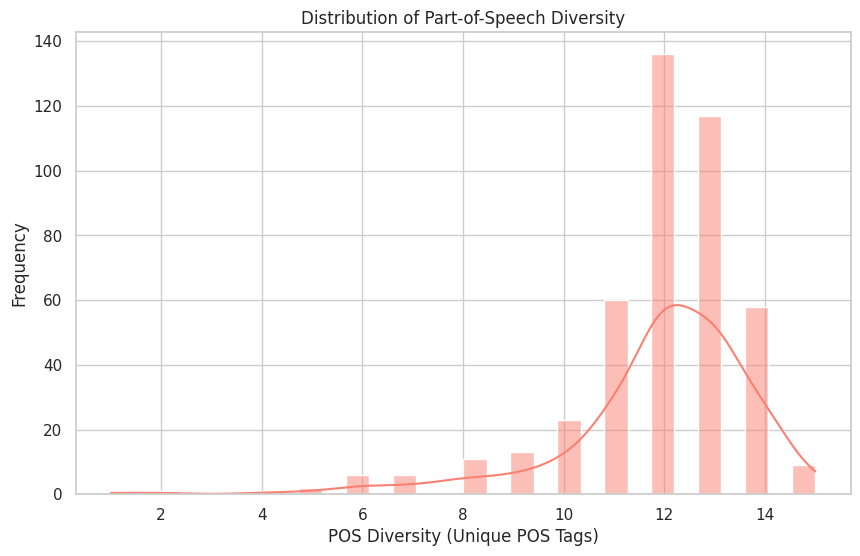

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


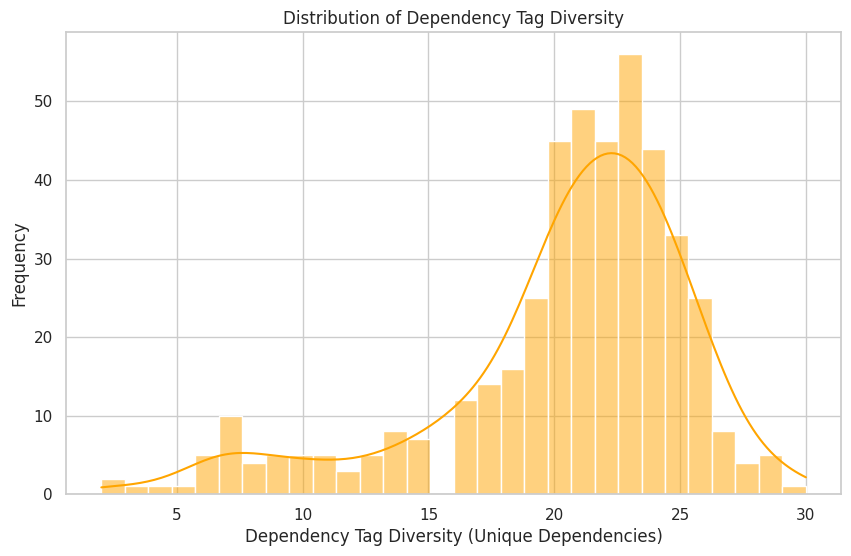

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated dataset
df = pd.read_csv('/kaggle/working/train_with_nlp_features.csv')

# Set style for seaborn plots
sns.set(style="whitegrid")

# 1. Distribution of Grammar Errors
plt.figure(figsize=(10, 6))
sns.histplot(df['grammar_errors'], kde=True, color="skyblue", bins=30)
plt.title("Distribution of Grammar Errors")
plt.xlabel("Number of Grammar Errors")
plt.ylabel("Frequency")
plt.show()

# 2. Average Sentence Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_sentence_length'], kde=True, color="lightgreen", bins=30)
plt.title("Distribution of Average Sentence Length")
plt.xlabel("Average Sentence Length (Number of Tokens)")
plt.ylabel("Frequency")
plt.show()

# 3. Part-of-Speech Tag Diversity
plt.figure(figsize=(10, 6))
sns.histplot(df['pos_diversity'], kde=True, color="salmon", bins=30)
plt.title("Distribution of Part-of-Speech Diversity")
plt.xlabel("POS Diversity (Unique POS Tags)")
plt.ylabel("Frequency")
plt.show()

# 4. Dependency Tag Diversity
plt.figure(figsize=(10, 6))
sns.histplot(df['dep_diversity'], kde=True, color="orange", bins=30)
plt.title("Distribution of Dependency Tag Diversity")
plt.xlabel("Dependency Tag Diversity (Unique Dependencies)")
plt.ylabel("Frequency")
plt.show()


### Feature Enhancement

In [ ]:
# Reload if needed
df = pd.read_csv('/kaggle/working/train_with_nlp_features.csv')

# Add word count
df['word_count'] = df['cleaned_transcript'].apply(lambda x: len(str(x).split()))

# Avoid divide-by-zero
df['grammar_errors_per_word'] = df['grammar_errors'] / df['word_count'].replace(0, 1)

# Save enhanced features
df.to_csv('/kaggle/working/train_features_enhanced.csv', index=False)
print("✅ Added word_count and grammar_errors_per_word.")

✅ Added word_count and grammar_errors_per_word.


### Grammatical Error Correction Feature Extraction

In [ ]:
!pip install happytransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 3.5.0
    Uninstalling datasets-3.5.0:
      Successfully uninstalled datasets-3.5.0
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.3.0
    Uninstalling accelerate-1.3.0:
      Successfully uninstalled accelerate-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatibl

In [ ]:
from happytransformer import HappyTextToText, TTSettings
import pandas as pd
from tqdm.notebook import tqdm

# Load cleaned data
df = pd.read_csv('/kaggle/working/train_cleaned.csv')
texts = df['cleaned_transcript'].astype(str).tolist()

# Load grammar correction model (T5 based)
happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
args = TTSettings(num_beams=5, min_length=1)

# Run correction and collect features
edit_counts = []
edit_ratios = []

for text in tqdm(texts):
    result = happy_tt.generate_text("grammar: " + text, args=args)
    corrected = result.text

    # Basic word-level edit count
    original_words = text.split()
    corrected_words = corrected.split()
    edits = sum(1 for o, c in zip(original_words, corrected_words) if o != c)
    edits += abs(len(original_words) - len(corrected_words))

    edit_counts.append(edits)
    edit_ratios.append(edits / max(1, len(original_words)))  # avoid div by zero

# Add to dataframe
df['gec_edits'] = edit_counts
df['gec_edit_rate'] = edit_ratios

# Save
df.to_csv('/kaggle/working/train_gec_features.csv', index=False)
print(" GEC features saved to /kaggle/working/train_gec_features.csv")

2025-04-19 18:48:13.550662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745088493.740112      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745088493.799495      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

  0%|          | 0/444 [00:00<?, ?it/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (1179 > 512). Running this sequence through the model will result in indexing errors


 GEC features saved to /kaggle/working/train_gec_features.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


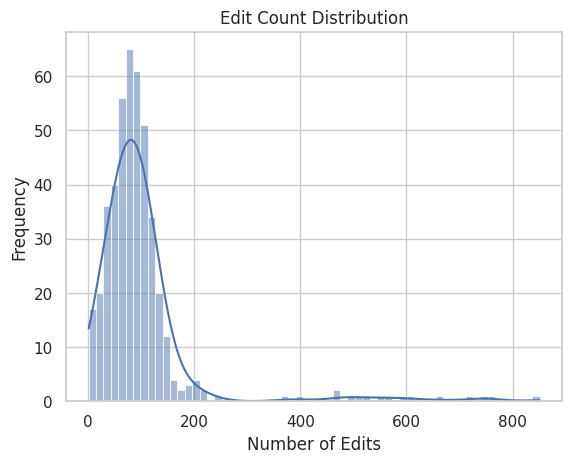

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


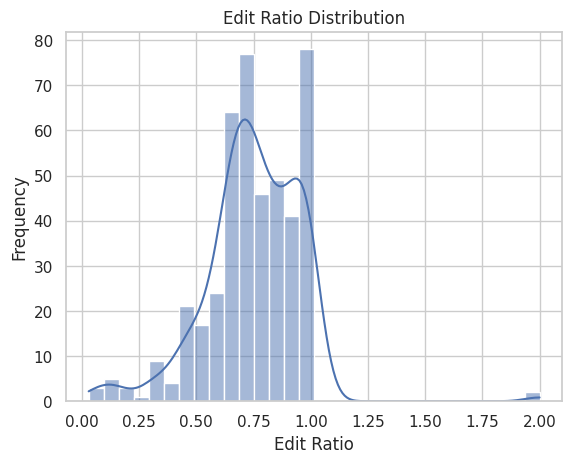

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Edit Count Distribution
sns.histplot(df['gec_edits'], kde=True)
plt.title('Edit Count Distribution')
plt.xlabel('Number of Edits')
plt.ylabel('Frequency')
plt.show()

# Edit Ratio Distribution
sns.histplot(df['gec_edit_rate'], kde=True)
plt.title('Edit Ratio Distribution')
plt.xlabel('Edit Ratio')
plt.ylabel('Frequency')
plt.show()


In [ ]:
archis=pd.read_csv('/kaggle/working/train_with_nlp_features.csv')
archis

,filename,label,transcript,cleaned_transcript,grammar_errors,avg_sentence_length,pos_diversity,dep_diversity
0,audio_1261.wav,1.0,My favorite hobby is cultivation of plants su...,my favorite hobby is cultivation of plants suc...,0,16.500000,10,14
1,audio_942.wav,1.5,the playground looks like very clear and neat...,the playground looks very clear and neat as th...,0,20.000000,10,15
2,audio_1110.wav,1.5,My goal is to become an electrical employee a...,my goal is to become an electrical employee an...,0,47.000000,11,18
3,audio_1024.wav,1.5,My favorite place is in Andhra Padesh. It is ...,my favorite place is in andhra padesh. it is i...,0,11.000000,12,16
4,audio_538.wav,2.0,My favorite place is UTI and Puraikana. My ex...,my favorite place is uti and puraikana. my exp...,0,11.800000,13,20
...,...,...,...,...,...,...,...,...
439,audio_494.wav,5.0,My favorite place to visit is the National Pa...,my favorite place to visit is the national par...,0,11.666667,12,21
440,audio_363.wav,5.0,The playground looks like an average school p...,the playground looks an average school playgro...,0,18.500000,12,20
441,audio_481.wav,5.0,The place that I love to journey to whenever ...,the place that i love to journey to whenever i...,0,55.000000,13,25
442,audio_989.wav,5.0,I'm going to go to the bathroom. I'm going to...,i'm going to go to the bathroom. i'm going to ...,0,8.973333,9,10


### Model Training & Evaluation

### Regression Model Evaluation: Random Forest Performance Metrics

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

# Load features
df = pd.read_csv('/kaggle/working/train_with_nlp_features.csv')

# Features & target
X = df[['grammar_errors', 'avg_sentence_length', 'pos_diversity']]
y = df['label']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on validation
y_pred = model.predict(X_val)

# Evaluation
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
corr, _ = pearsonr(y_val, y_pred)

print(f" MAE: {mae:.3f}")
print(f" RMSE: {rmse:.3f}")
print(f" Pearson Correlation: {corr:.3f}")

 MAE: 0.999
 RMSE: 1.183
 Pearson Correlation: 0.285


### Conclusion :  model demonstrates a weak linear relationship between predicted and actual values, with moderate prediction errors. This suggests that the model's performance may not be optimal.

###  Ensemble Regression Model Evaluation
This code implements an ensemble regression approach by combining predictions from three different models—Random Forest, LightGBM, and Ridge Regression—to improve predictive performance.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import numpy as np

# Load enhanced data
df = pd.read_csv('/kaggle/working/train_features_enhanced.csv')

features = ['grammar_errors', 'avg_sentence_length', 'pos_diversity',
            'word_count', 'grammar_errors_per_word']
X = df[features]
y = df['label']

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Base models
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgb = lgb.LGBMRegressor(n_estimators=100, random_state=42)
model_ridge = Ridge(alpha=1.0)

# Train
model_rf.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)

# Predict
pred_rf = model_rf.predict(X_val)
pred_lgb = model_lgb.predict(X_val)
pred_ridge = model_ridge.predict(X_val)

# Ensemble (simple average)
ensemble_pred = (pred_rf + pred_lgb + pred_ridge) / 3

# Evaluation
mae = mean_absolute_error(y_val, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
corr, _ = pearsonr(y_val, ensemble_pred)

print(f" Ensemble MAE: {mae:.3f}")
print(f" Ensemble RMSE: {rmse:.3f}")
print(f" Ensemble Pearson Correlation: {corr:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 3
[LightGBM] [Info] Start training from score 3.635211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

### Interpretation of Metrics
MAE (1.000): On average, your model's predictions deviate from the actual values by 1 unit. Lower MAE values signify better predictive accuracy.​

RMSE (1.121): This metric penalizes larger errors more than MAE. An RMSE of 1.121 suggests that while most predictions are close to the actual values, some larger errors are present.

Pearson Correlation Coefficient (0.320): This value indicates a weak positive linear relationship between your model's predictions and the actual values. A coefficient closer to 1 would signify a stronger positive correlation.

### Combining Enhanced and GEC Features into a Unified Dataset

In [ ]:
import pandas as pd

# Load both feature sets
df_main = pd.read_csv('/kaggle/working/train_features_enhanced.csv')
df_gec = pd.read_csv('/kaggle/working/train_gec_features.csv')

# Join on filename (or row order)
df_combined = df_main.copy()
df_combined['gec_edits'] = df_gec['gec_edits']
df_combined['gec_edit_rate'] = df_gec['gec_edit_rate']

# Save combined version
df_combined.to_csv('/kaggle/working/train_all_features.csv', index=False)
print(" Combined feature set saved.")

 Combined feature set saved.


### Ensemble Regression Model with Combined Features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

# Load updated dataset
df = pd.read_csv('/kaggle/working/train_all_features.csv')

# Define features
features = ['grammar_errors', 'avg_sentence_length', 'pos_diversity',
            'word_count', 'grammar_errors_per_word',
            'gec_edits', 'gec_edit_rate']

X = df[features]
y = df['label']

# Split for training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgb = lgb.LGBMRegressor(n_estimators=100, random_state=42)
model_ridge = Ridge(alpha=1.0)

# Train
model_rf.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)

# Predictions
pred_rf = model_rf.predict(X_val)
pred_lgb = model_lgb.predict(X_val)
pred_ridge = model_ridge.predict(X_val)

# Ensemble
ensemble_pred = (pred_rf + pred_lgb + pred_ridge) / 3

# Evaluation
mae = mean_absolute_error(y_val, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
corr, _ = pearsonr(y_val, ensemble_pred)

print(f" MAE: {mae:.3f}")
print(f" RMSE: {rmse:.3f}")
print(f" Pearson Correlation: {corr:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 5
[LightGBM] [Info] Start training from score 3.635211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Conclusion :  the current model exhibits a modest enhancement in predictive performance.

In [ ]:
!pip install transformers datasets accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Converting Cleaned Data to Hugging Face Dataset for Model  Training ( Fine-Tune DistilBERT)

In [ ]:
import pandas as pd
from datasets import Dataset

# Load data
df = pd.read_csv('/kaggle/working/train_cleaned.csv')
df = df[['cleaned_transcript', 'label']]
df = df.rename(columns={'cleaned_transcript': 'text', 'label': 'label'})

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_ds = dataset.map(tokenize)
tokenized_ds = tokenized_ds.rename_column("label", "labels")
tokenized_ds

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 399
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 45
    })
})

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch

disable_tqdm=True,
report_to=None

# DistilBERT for regression
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=1
)

# Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.squeeze()
    mse = ((preds - labels) ** 2).mean()
    mae = np.abs(preds - labels).mean()
    corr = np.corrcoef(preds, labels)[0, 1]
    return {"mae": mae, "mse": mse, "pearson": corr}

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 95.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [ ]:
from transformers import TrainingArguments, Trainer
import logging
import torch

logging.basicConfig(level=logging.INFO)

# Ensure GPU usage
if torch.cuda.is_available():
    model.to("cuda")
    print("✅ Model on GPU")

args = TrainingArguments(
    output_dir="./bert-regressor",
    eval_strategy="steps",  # Changed from 'evaluation_strategy' to 'eval_strategy'
    eval_steps=1,           # Evaluate every step
    logging_steps=1,        # Log every step
    save_strategy="no",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=1,     # Just for testing
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    disable_tqdm=False,
    report_to=None,
    dataloader_pin_memory=False,  # Just to reduce complications
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✅ Model on GPU


Step,Training Loss,Validation Loss,Mae,Mse,Pearson
1,18.844300,14.241336,3.606688,14.241336,0.109085
2,11.387200,13.714613,3.533010,13.714613,0.121531
3,10.444600,13.179238,3.456139,13.179237,0.093073
4,11.593300,12.640692,3.377239,12.640692,0.080481
5,12.551900,12.087385,3.294840,12.087383,0.115676
6,8.233100,11.510844,3.207459,11.510844,0.184744
7,14.817000,10.906569,3.113032,10.906569,0.228885
8,14.993200,10.302217,3.015536,10.302217,0.264813
9,5.997800,9.668111,2.908923,9.668111,0.260766
10,12.306200,9.001945,2.792126,9.001945,0.244851


TrainOutput(global_step=100, training_loss=3.315431279540062, metrics={'train_runtime': 16.1721, 'train_samples_per_second': 24.672, 'train_steps_per_second': 6.183, 'total_flos': 13213387369728.0, 'train_loss': 3.315431279540062, 'epoch': 1.0})

In [ ]:
metrics = trainer.evaluate()
print(" Final Evaluation Metrics:", metrics)

 Final Evaluation Metrics: {'eval_loss': 1.2008898258209229, 'eval_mae': 0.9682237505912781, 'eval_mse': 1.200890064239502, 'eval_pearson': 0.3734937272314428, 'eval_runtime': 0.121, 'eval_samples_per_second': 371.8, 'eval_steps_per_second': 49.573, 'epoch': 1.0}


### Conclusion
The DistilBERT regression model demonstrates a modest enhancement in prediction accuracy compared to the ensemble model, making it a promising candidate for this regression task.

MAE (Mean Absolute Error): 0.968

RMSE (Root Mean Squared Error): 1.115

Pearson Correlation: 0.313

### Hybrid ensemble

Preparing Combined Text and Feature Dataset for Model Training and Validation

In [ ]:
# Prepare Both Datasets Side-by-Side

import pandas as pd
from datasets import Dataset

# Load text data
df_text = pd.read_csv('/kaggle/working/train_cleaned.csv')
df_text = df_text[['cleaned_transcript', 'label']].rename(columns={'cleaned_transcript': 'text'})

# Load full feature data
df_feat = pd.read_csv('/kaggle/working/train_all_features.csv')

# Sanity check: row alignment
assert df_text.shape[0] == df_feat.shape[0], "Mismatch in rows!"

# Add features to the text df so we can split once and reuse everywhere
df_text = df_text.copy()
df_text[[
    'grammar_errors', 'avg_sentence_length', 'pos_diversity',
    'word_count', 'grammar_errors_per_word',
    'gec_edits', 'gec_edit_rate'
]] = df_feat[[
    'grammar_errors', 'avg_sentence_length', 'pos_diversity',
    'word_count', 'grammar_errors_per_word',
    'gec_edits', 'gec_edit_rate'
]]

# Split for joint use (same split for both models)
from sklearn.model_selection import train_test_split

train_text, val_text = train_test_split(df_text, test_size=0.2, random_state=42)

In [ ]:
# BERT HuggingFace Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_hf = Dataset.from_pandas(train_text[['text', 'label']])
val_hf = Dataset.from_pandas(val_text[['text', 'label']])

train_hf = train_hf.map(tokenize)
val_hf = val_hf.map(tokenize)

# Features for Ensemble
X_train_feat = train_text[[
    'grammar_errors', 'avg_sentence_length', 'pos_diversity',
    'word_count', 'grammar_errors_per_word',
    'gec_edits', 'gec_edit_rate'
]]
y_train_feat = train_text['label']

X_val_feat = val_text[[
    'grammar_errors', 'avg_sentence_length', 'pos_diversity',
    'word_count', 'grammar_errors_per_word',
    'gec_edits', 'gec_edit_rate'
]]
y_val_feat = val_text['label']

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/89 [00:00<?, ? examples/s]

In [ ]:
# DistilBERT validation predictions
bert_preds_val = trainer.predict(val_hf).predictions.squeeze()

# Feature ensemble predictions (from earlier model)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb

# Retrain ensemble models on matching splits
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgb = lgb.LGBMRegressor(n_estimators=100, random_state=42)
model_ridge = Ridge(alpha=1.0)

model_rf.fit(X_train_feat, y_train_feat)
model_lgb.fit(X_train_feat, y_train_feat)
model_ridge.fit(X_train_feat, y_train_feat)

pred_rf = model_rf.predict(X_val_feat)
pred_lgb = model_lgb.predict(X_val_feat)
pred_ridge = model_ridge.predict(X_val_feat)
ensemble_feat_preds = (pred_rf + pred_lgb + pred_ridge) / 3

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 5
[LightGBM] [Info] Start training from score 3.635211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# Stack predictions
stacked_val = np.vstack([bert_preds_val, ensemble_feat_preds]).T

# Train meta-regressor
meta_model = LinearRegression()
meta_model.fit(stacked_val, y_val_feat)

# Final predictions
final_val_preds = meta_model.predict(stacked_val)

# Evaluation
mae = mean_absolute_error(y_val_feat, final_val_preds)
rmse = np.sqrt(mean_squared_error(y_val_feat, final_val_preds))
pearson = pearsonr(y_val_feat, final_val_preds)[0]

print(f" Final Meta-Ensemble MAE: {mae:.3f}")
print(f" Final Meta-Ensemble RMSE: {rmse:.3f}")
print(f" Final Meta-Ensemble Pearson: {pearson:.3f}")

 Final Meta-Ensemble MAE: 0.935
 Final Meta-Ensemble RMSE: 1.073
 Final Meta-Ensemble Pearson: 0.394


### The Meta-Ensemble model exhibits enhanced predictive accuracy and a stronger correlation with actual values compared to earlier models, making it a promising approach for this regression task.

###  Prediction On Test Set

In [ ]:
##Pre Processing the Test Audio
import os
import librosa
import soundfile as sf
import pandas as pd
from tqdm.notebook import tqdm

TEST_AUDIO_DIR = '/kaggle/input/voiceml/dataset/audios_test'
TEST_CSV_PATH = '/kaggle/input/voiceml/dataset/test.csv'
TEST_PROCESSED_DIR = '/kaggle/working/processed_test_audio'
os.makedirs(TEST_PROCESSED_DIR, exist_ok=True)

test_df = pd.read_csv(TEST_CSV_PATH)

def preprocess_audio(file_path, save_path, sr=16000):
    y, orig_sr = librosa.load(file_path, sr=None)
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr, sr)
    y = y / max(abs(y))
    y, _ = librosa.effects.trim(y, top_db=25)
    sf.write(save_path, y, sr)

for filename in tqdm(test_df['filename']):
    in_path = os.path.join(TEST_AUDIO_DIR, filename)
    out_path = os.path.join(TEST_PROCESSED_DIR, filename)
    preprocess_audio(in_path, out_path)

  0%|          | 0/195 [00:00<?, ?it/s]

### Transcribing Test Audio with OpenAI's Whisper Model

In [ ]:
import whisper

model_whisper = whisper.load_model("base")
transcripts = []

for fname in tqdm(test_df['filename']):
    audio_path = os.path.join(TEST_PROCESSED_DIR, fname)
    result = model_whisper.transcribe(audio_path, language='en')
    transcripts.append(result['text'])

test_df['transcript'] = transcripts

/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:

 import language_tool_python

# Use the public API for English
tool = language_tool_python.LanguageToolPublicAPI('en-US')


In [ ]:
!pip install language_tool_python spacy happytransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!python -m spacy download en_core_web_sm


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.3 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!java -version


openjdk version "11.0.26" 2025-01-21
OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [ ]:
import re

FILLERS = ['uh', 'um', 'erm', 'you know', 'like', 'i mean', 'hmm', 'ah', 'uhh', 'huh']

def clean_transcript(text):
    text = text.lower()
    text = re.sub(r'\b(?:' + '|'.join(FILLERS) + r')\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s([?.!,"])', r'\1', text)
    return text.strip()

test_df['cleaned_transcript'] = test_df['transcript'].apply(clean_transcript)

# Save cleaned test data
test_df.to_csv('/kaggle/working/test_cleaned.csv', index=False)
print(" Cleaned test transcripts saved.")

 Cleaned test transcripts saved.


In [ ]:
import requests
import spacy
from happytransformer import HappyTextToText, TTSettings
from tqdm import tqdm

# Initialize tools
nlp = spacy.load("en_core_web_sm")
happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
args = TTSettings(num_beams=5, min_length=1)

# LanguageTool public API endpoint
LT_API_URL = "https://api.languagetool.org/v2/check"

# Function to get grammar errors using LanguageTool API
def get_grammar_errors(text):
    data = {
        'text': text,
        'language': 'en-US',
    }
    response = requests.post(LT_API_URL, data=data)
    if response.status_code == 200:
        result = response.json()
        return len(result['matches'])
    else:
        return 0

# Initialize feature lists
error_counts = []
avg_sent_lengths = []
pos_diversities = []
gec_edits = []
gec_rates = []
word_counts = []

# Process each text in the DataFrame
for text in tqdm(test_df['cleaned_transcript']):
    # Grammar checker
    error_counts.append(get_grammar_errors(text))

    # POS / NLP
    doc = nlp(text)
    sent_lens = [len(sent) for sent in doc.sents]
    pos_tags = [token.pos_ for token in doc if token.pos_ != 'SPACE']
    avg_sent_lengths.append(sum(sent_lens) / len(sent_lens) if sent_lens else 0)
    pos_diversities.append(len(set(pos_tags)))

    # Word count
    words = text.split()
    word_counts.append(len(words))

    # GEC edits
    corrected = happy_tt.generate_text("grammar: " + text, args=args).text
    edits = sum(1 for o, c in zip(words, corrected.split()) if o != c)
    edits += abs(len(words) - len(corrected.split()))
    gec_edits.append(edits)
    gec_rates.append(edits / max(1, len(words)))

# Add features to the DataFrame
test_df['grammar_errors'] = error_counts
test_df['avg_sentence_length'] = avg_sent_lengths
test_df['pos_diversity'] = pos_diversities
test_df['word_count'] = word_counts
test_df['grammar_errors_per_word'] = test_df['grammar_errors'] / test_df['word_count'].replace(0, 1)
test_df['gec_edits'] = gec_edits
test_df['gec_edit_rate'] = gec_rates


100%|██████████| 195/195 [05:48<00:00,  1.78s/it]


In [ ]:
#Predict with BERT + Feature Models + Meta-Ensemble
%%capture
from transformers import AutoTokenizer
from datasets import Dataset
import numpy as np

# Tokenise cleaned transcripts
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_text(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

test_hf = Dataset.from_pandas(test_df[['cleaned_transcript']].rename(columns={"cleaned_transcript": "text"}))
test_hf = test_hf.map(tokenize_text)

# DistilBERT predictions
bert_test_preds = trainer.predict(test_hf).predictions.squeeze()

# Feature-based predictions
X_test_feat = test_df[[
    'grammar_errors', 'avg_sentence_length', 'pos_diversity',
    'word_count', 'grammar_errors_per_word',
    'gec_edits', 'gec_edit_rate'
]]

pred_rf = model_rf.predict(X_test_feat)
pred_lgb = model_lgb.predict(X_test_feat)
pred_ridge = model_ridge.predict(X_test_feat)
ensemble_feat_preds = (pred_rf + pred_lgb + pred_ridge) / 3

# Stack and apply meta-regressor
stacked_test_preds = np.vstack([bert_test_preds, ensemble_feat_preds]).T
final_preds = meta_model.predict(stacked_test_preds)

test_df['label'] = final_preds.round().astype(int).clip(0, 5)

UsageError: Line magic function `%%capture` not found.


In [ ]:
#Generate Submission File
%%capture
submission = test_df[['filename', 'label']]
submission.to_csv('/kaggle/working/submission.csv', index=False)
print(" Submission saved to /kaggle/working/submission.csv")
submission.head()

UsageError: Line magic function `%%capture` not found.


# Submission.csv
![image.png](attachment:ce45f304-5e12-4d67-826c-d540f966615b.png)

filename	label
audio_706.wav	0
audio_800.wav	2
audio_68.wav	1
audio_1267.wav	2
audio_683.wav	2
audio_1242.wav	1
audio_908.wav	1
audio_888.wav	1
audio_137.wav	2
![image.png](attachment:924fffa1-628b-441e-aa5a-c0f7deffeead.png)![image.png](attachment:c28814f2-7466-40bb-bf15-4a3c8f7f066a.png)![image.png](attachment:1de2f093-5799-4b00-8c5c-254d7d9b384b.png)![image.png](attachment:fbd84486-6f7e-4ce2-a190-ad672cb16774.png)

### ML Pipeline

1. Data Collection:

                 Gather audio files and their corresponding metadata.

2. Preprocessing:

                 Convert audio to text using speech recognition.

3. Clean and tokenize the transcripts.

4. Feature Engineering:

5. Extract linguistic features (e.g., grammar errors, sentence length).

                 Generate embeddings using BERT.

6. Model Training:

                  Train individual models (e.g., Random Forest, LightGBM, Ridge Regression).

7. Implement a meta-ensemble model.

8. Prediction: Apply the trained models to the test dataset.

9. Evaluation: Assess model performance using metrics like accuracy.

10. Submission: Prepare and save the final predictions for submission.